# Notebook to make Taylor diagrams

In [100]:
# Make other folders visible
import sys
sys.path.insert(1, '/home/jovyan/CMIP6_OceanAtlas/utils')

# imports
from taylor_diagram import TaylorDiagram
import matplotlib.pyplot as plt
import intake
import matplotlib.pyplot as plt

In [101]:
import xarray as xr
import pandas as pd
import cartopy as cart
import matplotlib.pylab as plt
from matplotlib import cm
import datetime
import cmocean
import numpy as np
import dateutil

# Load data

In [102]:
# model params 
# will need to do the same for obs
var = 'dissic'
model = 'CanESM5'
member = 'r10i1p1f1'
section = '06AQ20050122'
root_dir = '/home/jovyan/sections'

# load obs dic
fl_obs = f'{root_dir}/{var}_{model}_{member}_{section}.nc'
ds_obs = xr.open_dataset(fl_obs)

# load model dic
fl_mod = f'{root_dir}/{var}_{model}_{member}_{section}.nc'
ds_mod = xr.open_dataset(fl_mod)

# rename variable to differentiatte obs and model
ds_obs = ds_obs.rename({f'{var}': f'{var}_obs'})
ds_mod = ds_mod.rename({f'{var}': f'{var}_mod'})

# Put in dataframe

# Statistics

In [103]:
dict_params = { 'var' : 'dissic',
                'model': 'CanESM5',
                'member': 'r10i1p1f1',
                'section': '06AQ20050122',
                'root_dir': '/home/jovyan/sections'}

In [104]:
def get_stats(ds_obs, ds_mod, dict_params=None):
    '''
    get_stats(ds_obs, ds_mod, var)
    make a dictionary of statistics 
    
    Input
    =========
    ds_obs : xarray datarray of model
    ds_mod : xarray datarray of obs
    var : variable name you are looking at
    
    Output
    ==========
    stats_dict : dictionary of statistics comparing model and obsrvations 
    
    '''
    var = dict_params['var']
    model = dict_params['model']
    member = dict_params['member']
    section = dict_params['section']
    root_dr = dict_params['root_dir']

    # load obs dic
    fl_obs = f'{root_dir}/{var}_{model}_{member}_{section}.nc'
    ds_obs = xr.open_dataset(fl_obs)

    # load model dic
    fl_mod = f'{root_dir}/{var}_{model}_{member}_{section}.nc'
    ds_mod = xr.open_dataset(fl_mod)

    # rename variable to differentiatte obs and model
    ds_obs = ds_obs.rename({f'{var}': f'{var}_obs'})
    ds_mod = ds_mod.rename({f'{var}': f'{var}_mod'})


    # merge xarray datasets
    ds_merge = ds_obs.merge(ds_mod)

    # make a dataframe and drop nans
    ds_merge_nonan = ds_merge.to_dataframe().dropna()

    # Calculate various statistics 
    bias = ds_merge_nonan[f'{var}_mod'].mean() - ds_merge_nonan[f'{var}_obs'].mean()
    rmse = ((ds_merge_nonan[f'{var}_obs'] - ds_merge_nonan[f'{var}_mod']) ** 2).mean() ** .5
    aae = np.abs(ds_merge_nonan[f'{var}_obs'] - ds_merge_nonan[f'{var}_mod']).mean()
    corr = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].corr(method='pearson').iloc[0,1]
    std_obs = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_obs']
    std_mod = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_mod']
    std_norm = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_mod'] /\
               ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_obs']

    # Put stats in dictionary
    stats_dict = {'var': var,
                 'model': model,
                 'member': member,
                 'section': section,
                 'corr': corr,
                 'std_obs' : std_obs,
                 'std_mod': std_mod, 
                 'std_norm': std_norm,
                 'rmse': rmse, 
                 'bias': bias}

    return stats_dict

In [105]:
stats_dict = get_stats(ds_obs, ds_mod, dict_params=dict_params)

In [106]:
stats_dict

{'var': 'dissic',
 'model': 'CanESM5',
 'member': 'r10i1p1f1',
 'section': '06AQ20050122',
 'corr': 1.0,
 'std_obs': 0.028664458233092216,
 'std_mod': 0.028664458233092216,
 'std_norm': 1.0,
 'rmse': 0.0,
 'bias': 0.0}

In [107]:
# dictionary of model colors
color_dict = {'CanESM5': 'g',
              'CESM':'b'}

In [108]:
model_list = ['CanESM2']
samples = [stats_dict['corr'], stats_dict['std_norm'], stats_dict['model'], color_dict[stats_dict['model']]]
#samples = [[10, 0.8 , "IPSL", 'b'],
#           [12, 0.6 , "NASA", 'g']]

In [109]:
samples

[1.0, 1.0, 'CanESM5', 'g']

# Taylor diagram

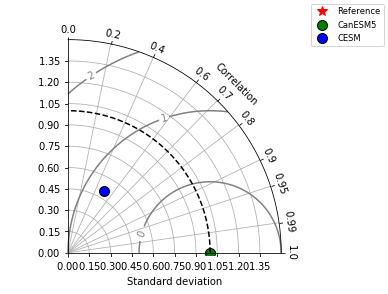

In [99]:
# Reference options 
ref_std = 1
ref_color = 'r'
ref_label = 'Reference'

# Samples list (maybe make a dictionary)
# -----------------------------------
#         std   rho   model  color
# -----------------------------------
samples = [[stats_dict['corr'], stats_dict['std_norm'], stats_dict['model'], color_dict[stats_dict['model']]],
          [0.5, 0.5, 'CESM', 'b']]

#===============================
# Generate Taylor Diagram
#===============================
fig = plt.figure()

# generate Taylor diagram object 
dia = TaylorDiagram(ref_std, label=ref_label, extend=False, fig=fig)

# mark reference point as a red star
dia.samplePoints[0].set_color(ref_color)  

# add models to Taylor diagram
for i, (stddev, corrcoef, name, col) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker='o', ms=10, ls='',
                   mfc=col, mec='k',
                   label=name)

#===============================
# RMSE contours 
# Levels : number RMSE lines 
# color  : color of contours gray
#===============================
# Add RMS contours, and label them
contours = dia.add_contours(levels=3, colors='0.5') 

# add labelto RMSE contours 
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

# Add grid lines 
dia.add_grid()                              

# Put ticks outward
dia._ax.axis[:].major_ticks.set_tick_out(True)  

# Add a figure legend and title
fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='upper right')

# Section difference

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)



minvalue_conc,maxvalue_conc,cmap,nsteps,labelstep,cfactor = cprops[ovar.name]

cstep = abs(minvalue_conc-maxvalue_conc)/nsteps

cbarstep = abs(minvalue_conc-maxvalue_conc)/(nsteps/4);

contour_levs = np.arange(minvalue_conc,maxvalue_conc+cstep,cstep)

contour_labels = np.arange(minvalue_conc,maxvalue_conc+cstep,labelstep)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.dpi=300
fig.set_figheight(4)
fig.set_figwidth(2.5)
ax1.set_title(f'{section.long_name}',fontsize=5)
cax = ax1.contourf(section.station,section.depth,section.T*cfactor,levels=contour_levs,extend='both',cmap=cmap)
ax2.contourf(section.station,section.depth,section.T*1e3,levels=contour_levs,extend='both',cmap=cmap)

cs1 = ax1.contour(section.station,section.depth,section.T*cfactor,levels=contour_levs,
                  extend='both',
                  colors='0.6',
                  linewidths=0.2)
ax1.clabel(cs1,fontsize=4,fmt='%1.f')

cs2 = ax2.contour(section.station,section.depth,section.T*cfactor,
                  levels=contour_levs,extend='both',
                  colors='0.6',
                  linewidths=0.2)
ax2.clabel(cs2,fontsize=4, fmt='%1.f')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
    ax2.spines[axis].set_linewidth(0.5)
    
ax1.tick_params(which='both', width=0.5)
ax2.tick_params(which='both', width=0.5)

ax1.set_facecolor('k')
ax2.set_facecolor('k')
ax1.set_ylim(1000,0)
ax2.set_ylim(6000,1000)

cbar_ax = fig.add_axes([0.95, 0.2, 0.04, 0.6])
cbar = fig.colorbar(cax, cax=cbar_ax,extend='both')
cbar.ax.tick_params(labelsize=5)
cbar.ax.tick_params(which='both', width=0.5)
cbar.outline.set_linewidth(0.5)

# Old pieces of code

In [ ]:
# load station information from csv file
#df = pd.read_csv('../qc/GLODAPv2.2019_COORDS.csv')

#df = df.dropna()
#df = df.reset_index().drop('Unnamed: 0',axis=1)

#df_obs = pd.read_csv('../data/GLODAPv2.2019_Merged_Master_File.csv')

#df_obs.head()


# Model
#url = "../catalogs/pangeo-cmip6.json"
#col = intake.open_esm_datastore(url)
#col

#cat = col.search(experiment_id=['historical'], 
#                 table_id='Omon', 
#                 variable_id='dissic',
#                 grid_label='gn')
#cat.df

#dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
#                                cdf_kwargs={'chunks': {}, 'decode_times': False})

#ds = dset_dict['CMIP.CCCma.CanESM5.historical.Omon.gn']

#ds['dissic'].squeeze().isel(lev=0).std('time')